<a href="https://colab.research.google.com/github/5213478/mr1/blob/main/all_class3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.8/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 1.3 MB/s 


In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/all class 33/"

Mounted at /content/gdrive/


In [ ]:
#%reset
#%tensorflow_version 1.x
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, GRU
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
EPOCHS = 100
NUM_CLASSES = 11
BATCH_SIZE = 1024
PATIENCE = 10

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, labels=[]):#改混淆矩阵颜色
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels, rotation=45)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + 'model1/%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = preprocessing.LabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
    
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20), (-20, -11), (-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_,)#混淆矩阵标题
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("SNR (dB)")#横轴标注
    plt.ylabel("Classification Accuracy")#纵轴标注
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])#纵轴间隔表示
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

In [ ]:
import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest3.hdf5')

KeyError: ignored

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (147400, 2, 128) (28600, 2, 128) (44000, 2, 128)
Check if data is shuffled:  [['QAM64' '12']
 ['QAM64' '-20']
 ['QAM64' '-20']
 ['CPFSK' '12']
 ['WBFM' '18']
 ['AM-DSB' '-20']
 ['PAM4' '-12']
 ['QAM64' '-4']
 ['PAM4' '12']
 ['QAM64' '10']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [7327 7467 7344 7417 7402 7428 7457 7344 7335 7355 7362 7329 7315 7407
 7362 7366 7483 7278 7306 7316]
Check modulation types:  ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Check distribution of samples across modulation types:  [13447 13432 13547 13458 13375 13356 13336 13320 13329 13403 13397]


In [ ]:
#load data
X_train = data['train']['X']
y_train = data['train']['labels'][:,0]
labels_train = data['train']['labels'] 

X_val = data['val']['X']
y_val = data['val']['labels'][:,0]
labels_val = data['val']['labels'] 

X_test = data['test']['X']
y_test = data['test']['labels'][:,0]
labels_test = data['test']['labels'] 

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

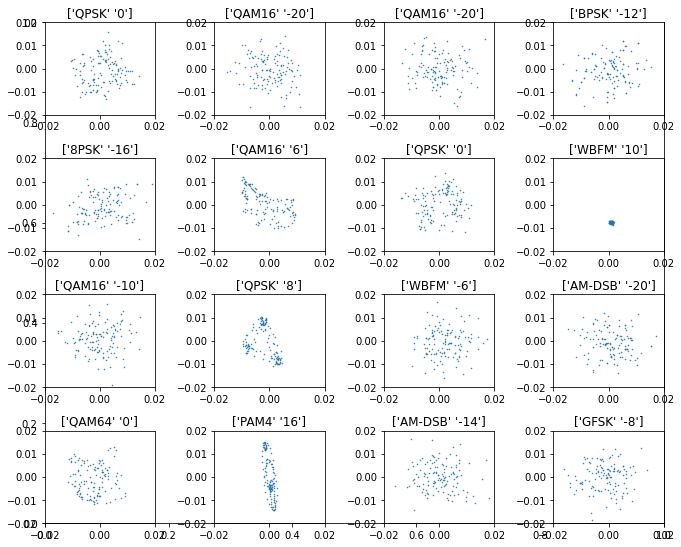

In [ ]:
#constellation diagrams
fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    plt.plot(I, Q, '.', markersize=1)
    plt.xlim(-0.02, 0.02)
    plt.ylim(-0.02, 0.02)
    plt.title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

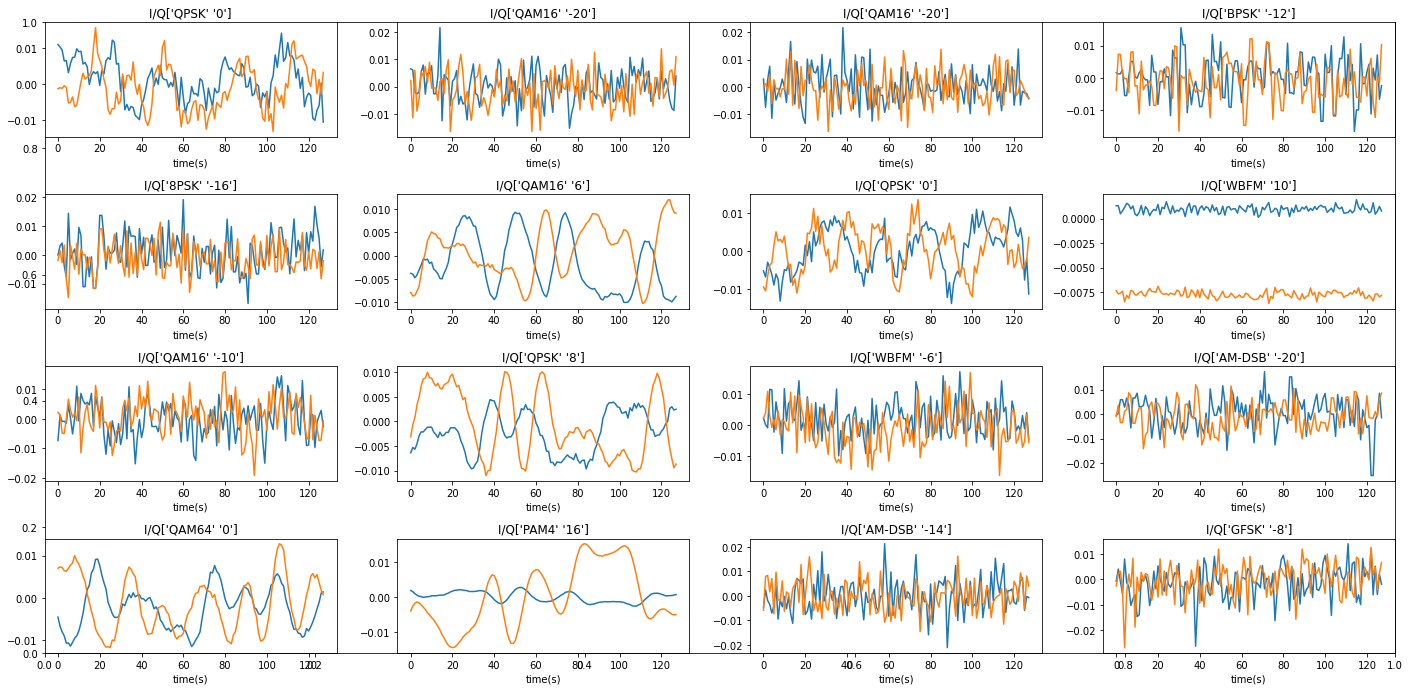

In [ ]:
#IQ time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.plot(I)
    ax.plot(Q)
    plt.title('I/Q' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

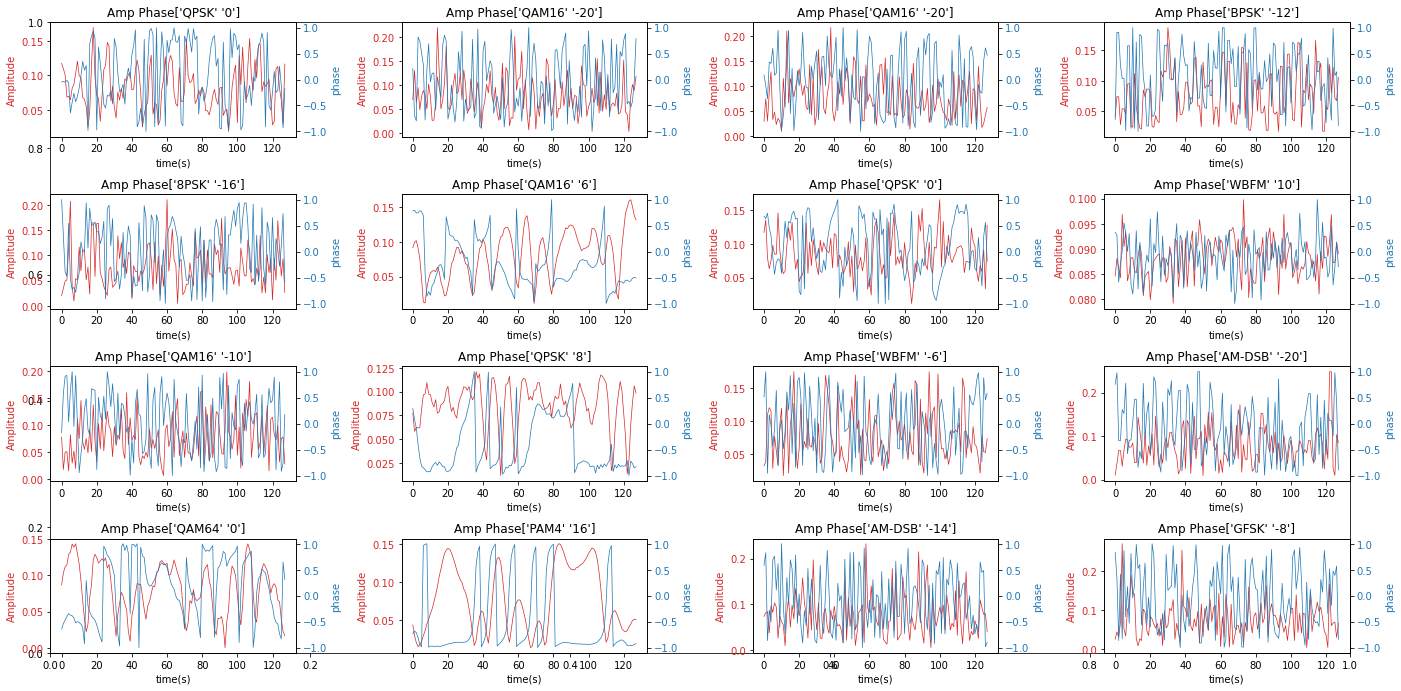

In [ ]:
#Amp-Phase time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    amp = X_ap_train[i][0,:]
    phase = X_ap_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.set_ylabel('Amplitude',color='tab:red')
    ax.plot(amp, color='tab:red', linewidth=0.7)
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax.twinx()
    ax2.set_ylabel('phase', color='tab:blue')
    ax2.plot(phase, color='tab:blue', linewidth=0.7)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.title('Amp Phase' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

In [ ]:
def build_cnn_net(X1, X2):
    dr = 0.4 # dropout rate (%)
    
    cnn_model = Sequential()
    cnn_model.add(Reshape((1,X1, X2), input_shape=(X1, X2)))
    cnn_model.add(Conv2D(256, (1,3), padding="valid", activation='relu', kernel_initializer='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Conv2D(80, (2, 3), padding="valid", activation='relu', kernel_initializer='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform'))
    cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    return cnn_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 256, 2, 126)       1024      
                                                                 
 dropout (Dropout)           (None, 256, 2, 126)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 1, 124)        122960    
                                                                 
 dropout_1 (Dropout)         (None, 80, 1, 124)        0         
                                                                 
 flatten (Flatten)           (None, 9920)              0         
                                                                 
 dense (Dense)               (None, 256)               2

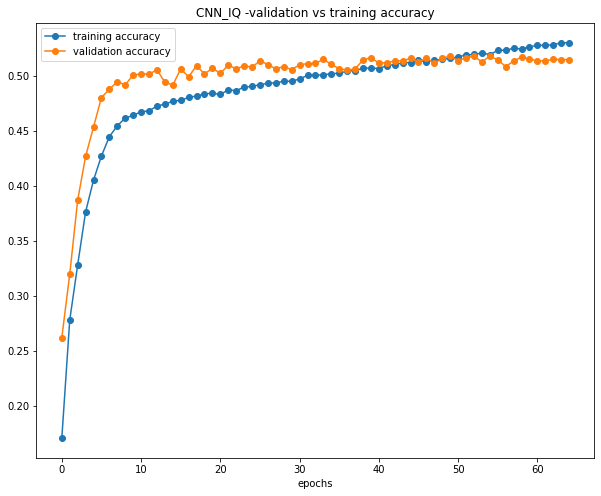

None

43/43 [==============================] - 1s 33ms/step


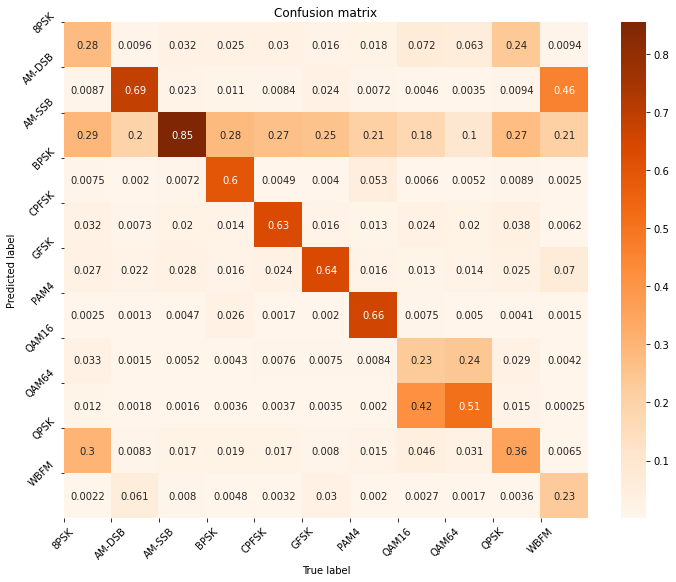

11/11 [==============================] - 1s 65ms/step


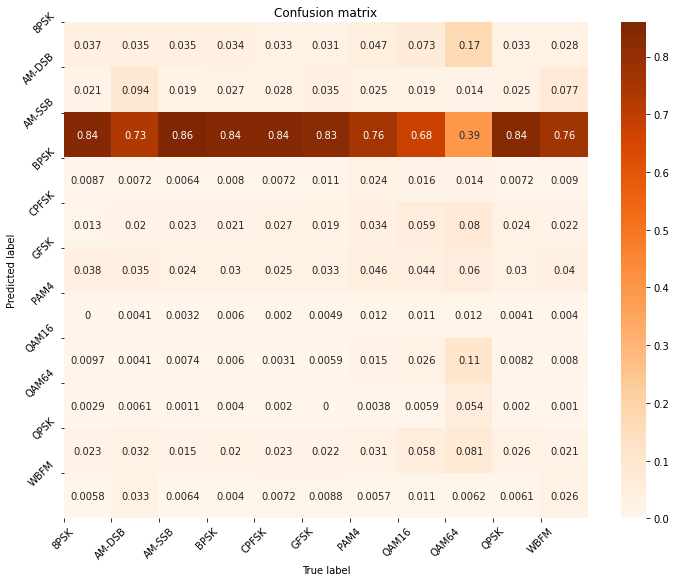

18/18 [==============================] - 1s 44ms/step


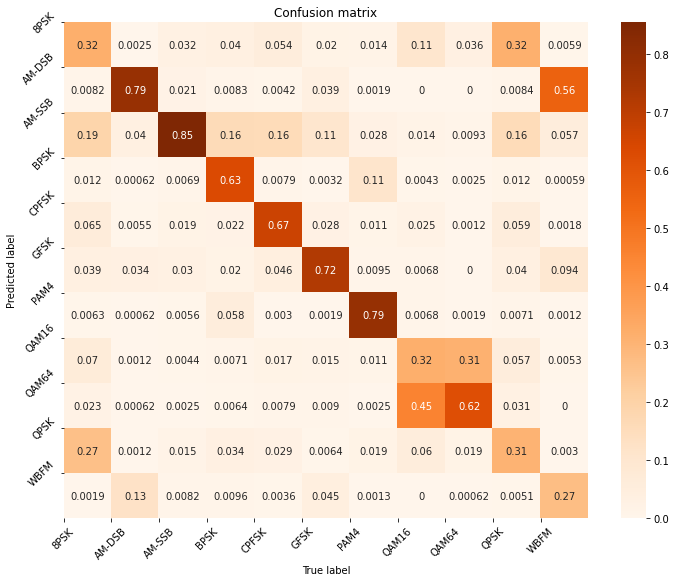

16/16 [==============================] - 0s 27ms/step


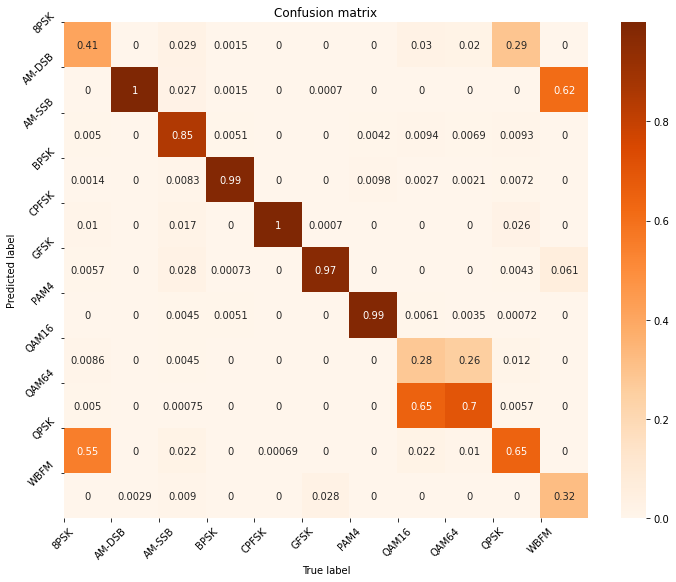

3/3 [==============================] - 0s 175ms/step


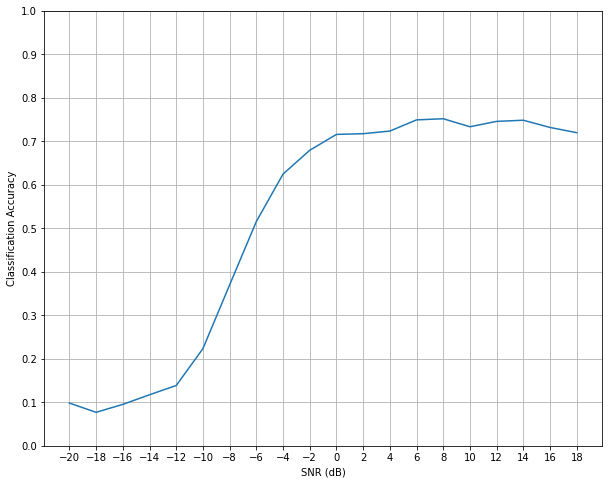

In [ ]:
cnn_model = build_cnn_net(X_test.shape[1], X_test.shape[2])
cnn_model_evaluater = ModelEvaluater(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'CNN_IQ' )
cnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_model_evaluater.print_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 2, 126)       1024      
                                                                 
 dropout_3 (Dropout)         (None, 256, 2, 126)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 1, 124)        122960    
                                                                 
 dropout_4 (Dropout)         (None, 80, 1, 124)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9920)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

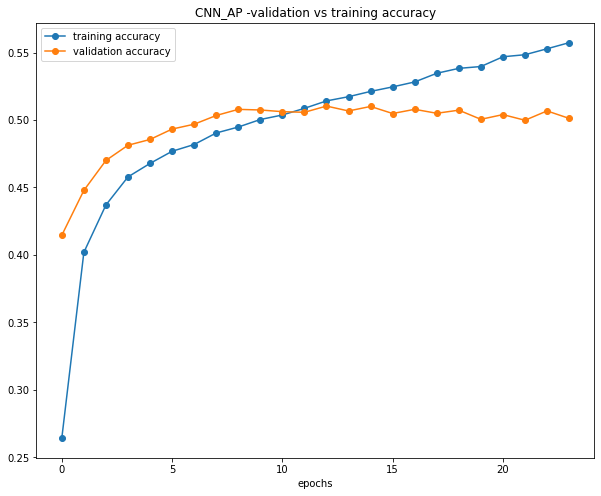

None

43/43 [==============================] - 1s 21ms/step


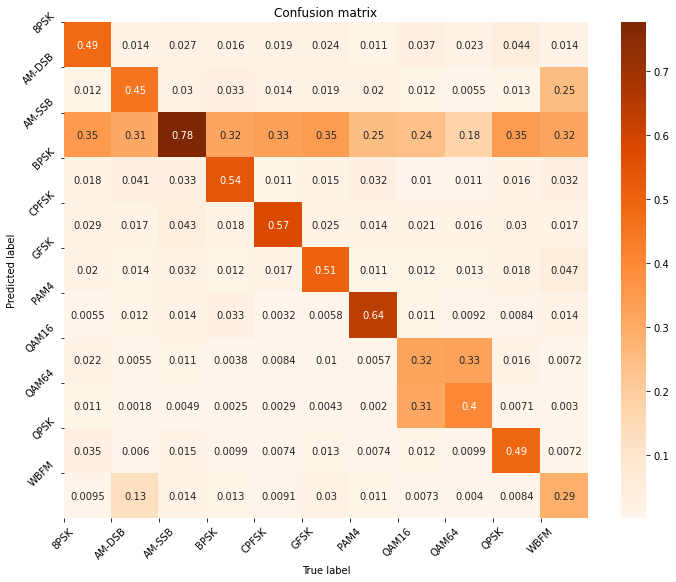

11/11 [==============================] - 0s 18ms/step


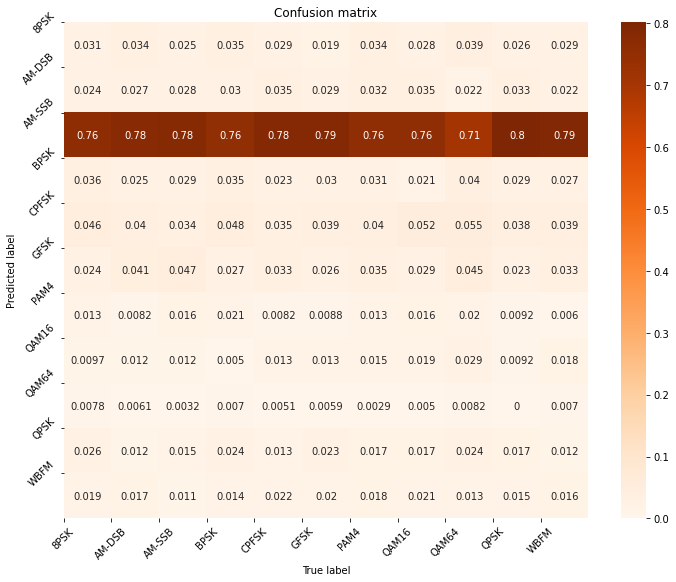

18/18 [==============================] - 0s 18ms/step


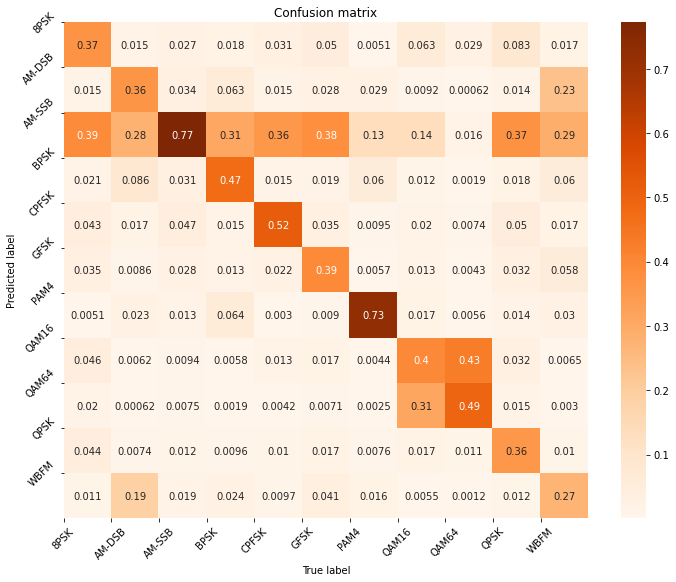

16/16 [==============================] - 0s 18ms/step


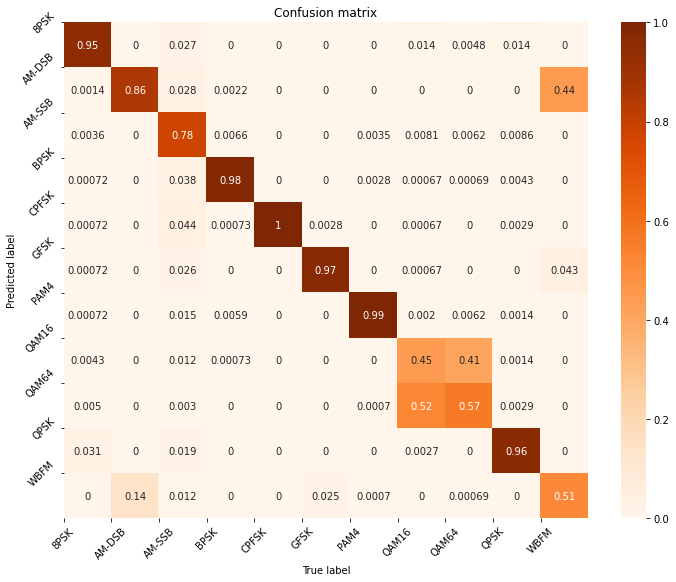

3/3 [==============================] - 0s 19ms/step


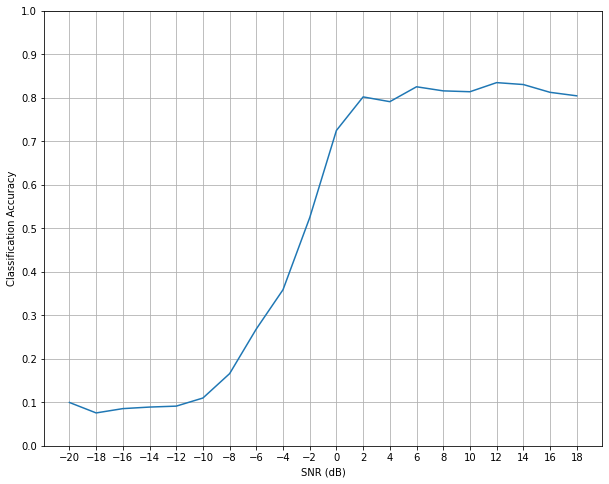

In [ ]:
cnn_ap_model = build_cnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cnn_ap_model_evaluater = ModelEvaluater(cnn_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'CNN_AP' )
cnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_ap_model_evaluater.print_summary()

In [ ]:
# 1d conv resnet
def residual_stack(x, f):
    # 1x1 conv linear
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    # residual unit 1    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # residual unit 2    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
def build_ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)

    adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 2)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 40)      120         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 40)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 128, 40)      4840        ['activation[0][0]']             
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 dense_5 (Dense)                (None, 128)          16512       ['dropout_6[0][0]']              
                                                                                                  
 dropout_7 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 11)           1419        ['dropout_7[0][0]']              
                                                                                                  
Total params: 142,019
Trainable params: 142,019
Non-trainable params: 0
__________________________________________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 2.1583 - accuracy: 0.2087
Epoch 1: val_loss improved from inf to 1.83861, saving model to /content/gdrive/My Drive/all class

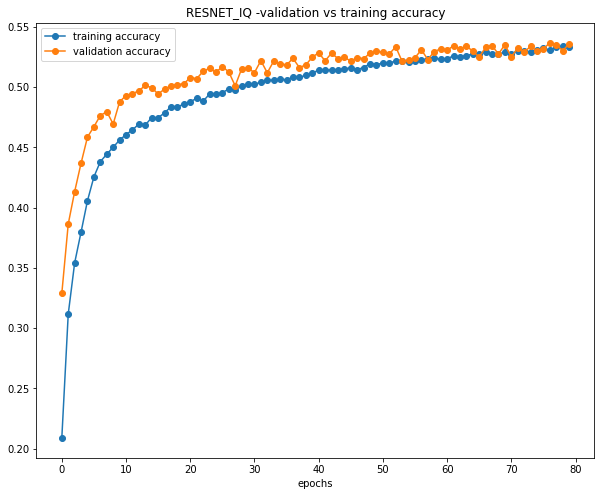

None

43/43 [==============================] - 2s 34ms/step


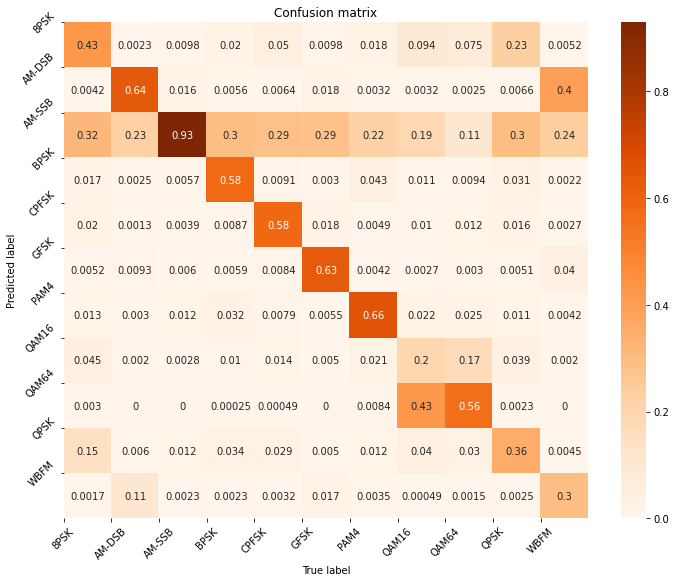

11/11 [==============================] - 1s 82ms/step


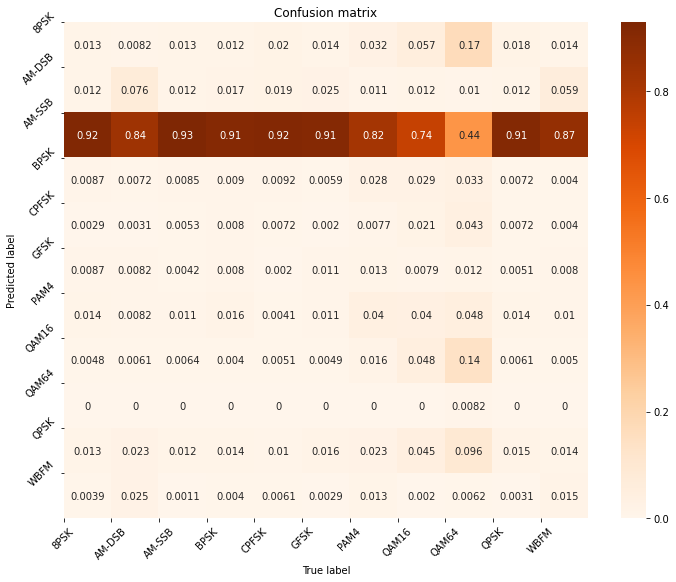

18/18 [==============================] - 1s 49ms/step


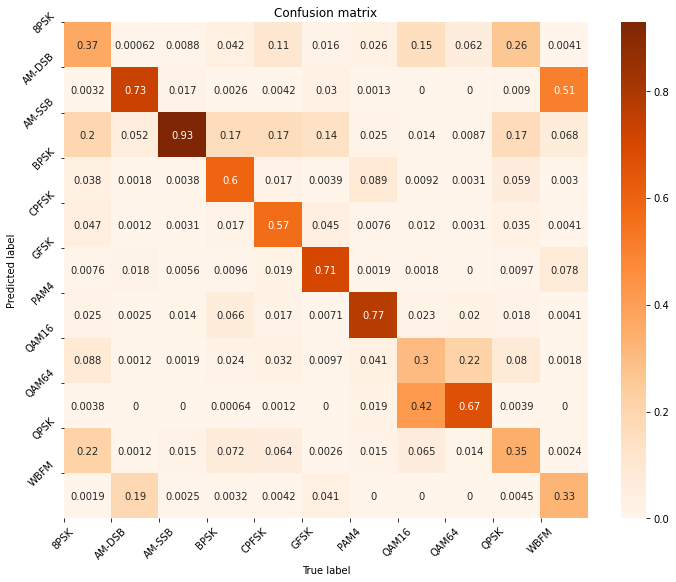

16/16 [==============================] - 1s 33ms/step


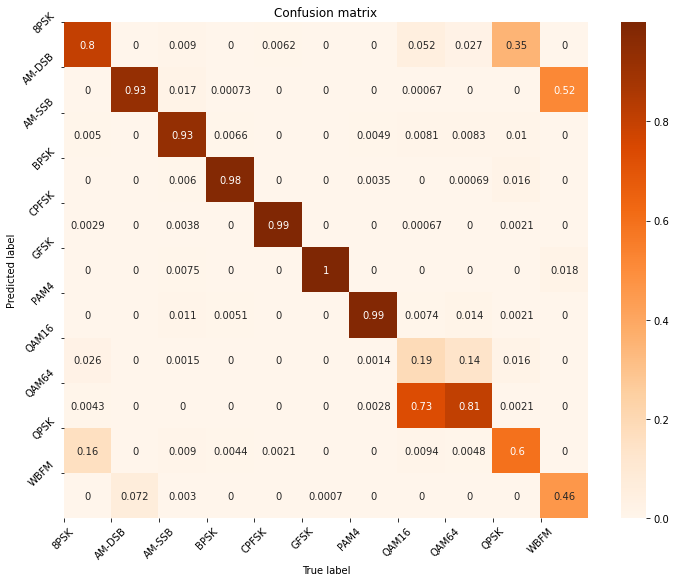

3/3 [==============================] - 1s 270ms/step


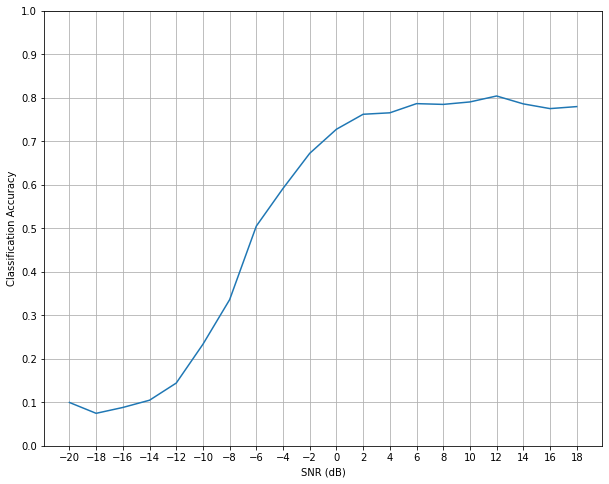

In [ ]:
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'RESNET_IQ', channels_first=False)
resnet_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_model_evaluater.print_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 2)]     0           []                               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 128, 40)      120         ['input_2[0][0]']                
                                                                                                  
 activation_25 (Activation)     (None, 128, 40)      0           ['conv1d_25[0][0]']              
                                                                                                  
 conv1d_26 (Conv1D)             (None, 128, 40)      4840        ['activation_25[0][0]']          
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 142,019
Trainable params: 142,019
Non-trainable params: 0
__________________________________________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 3.0903 - accuracy: 0.1050
Epoch 1: val_loss improved from inf to 2.29581, saving model to /content/gdrive/My Drive/all class 33/RESNET_AP-weights-1.hdf5
144/144 [==============================] - 11s 64ms/step - loss: 3.0903 - accuracy: 0.1050 - val_loss: 2.2958 - val_accuracy: 0.1720
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 2.3986 - accuracy: 0.1479
Epoch 2: val_loss improved from 2.29581 to 2.14813, saving model to /content/gdrive/My Drive/all class 33/RESNET_AP-weights-2.hdf5
144/144 [==============================] - 9s 60ms/step - loss: 2.3986 - accuracy: 0.1479 - val_loss: 2.1481 - val_accuracy: 0.2427
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 2

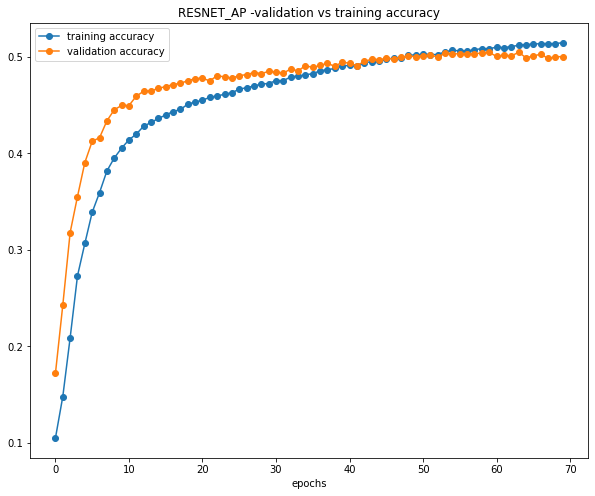

None

43/43 [==============================] - 1s 14ms/step


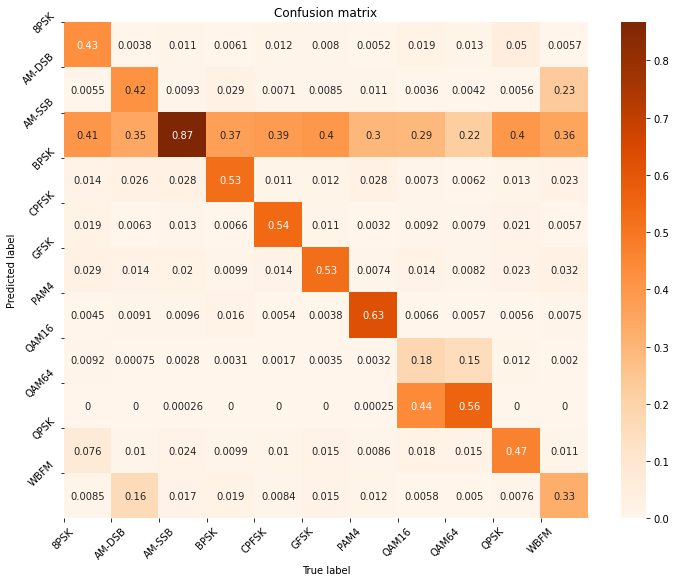

11/11 [==============================] - 0s 13ms/step


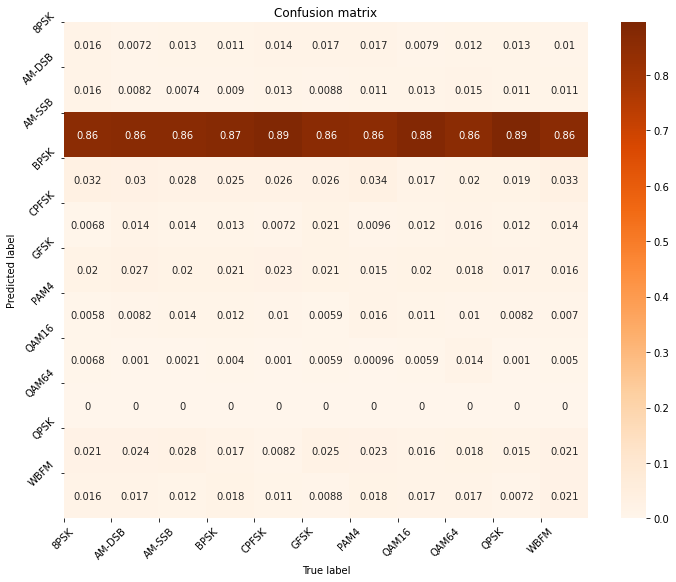

18/18 [==============================] - 0s 13ms/step


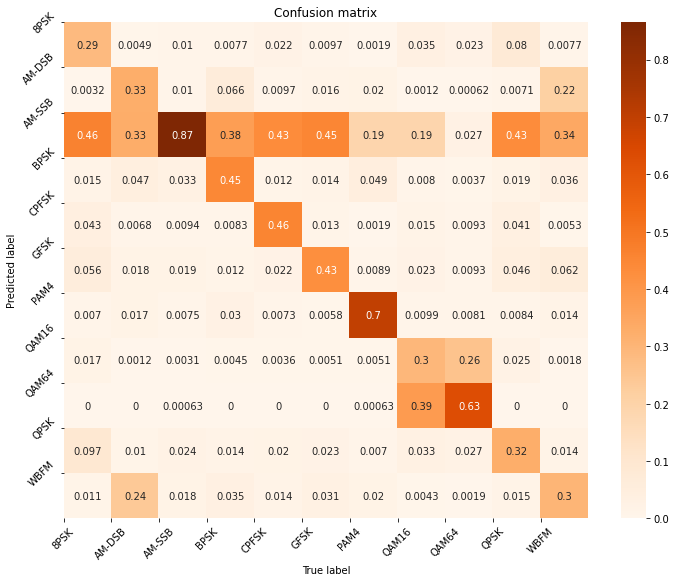

16/16 [==============================] - 0s 13ms/step


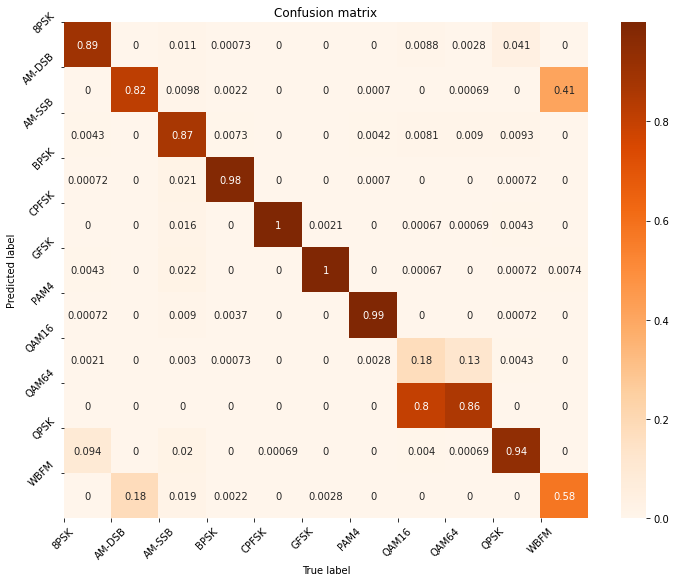

3/3 [==============================] - 0s 20ms/step


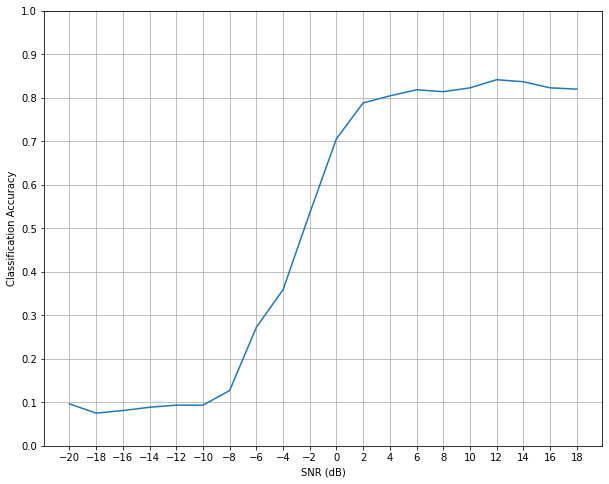

In [ ]:
resnet_ap_model = build_ResNet((X_ap_test.shape[2], X_ap_test.shape[1]), NUM_CLASSES)
resnet_ap_model_evaluater = ModelEvaluater(resnet_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'RESNET_AP', channels_first=False)
resnet_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_ap_model_evaluater.print_summary()

In [ ]:
def build_cldnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 3), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)

  concat = keras.layers.concatenate([layer1, layer3])
  
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1")(lstm_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, kernel_initializer='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_15 (ZeroPadding  (None, 1, 2, 132)   0           ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_15[0][0]']      
                                                                                                  
 dropout_30 (Dropout)           (None, 50, 2, 125)   0           ['conv1[0][0]']            

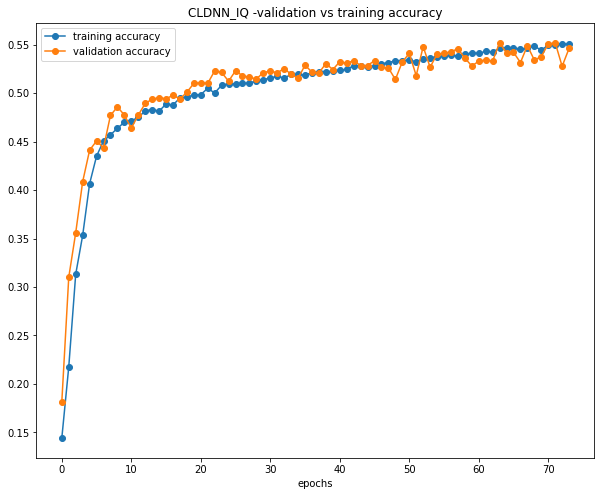

None

43/43 [==============================] - 1s 5ms/step


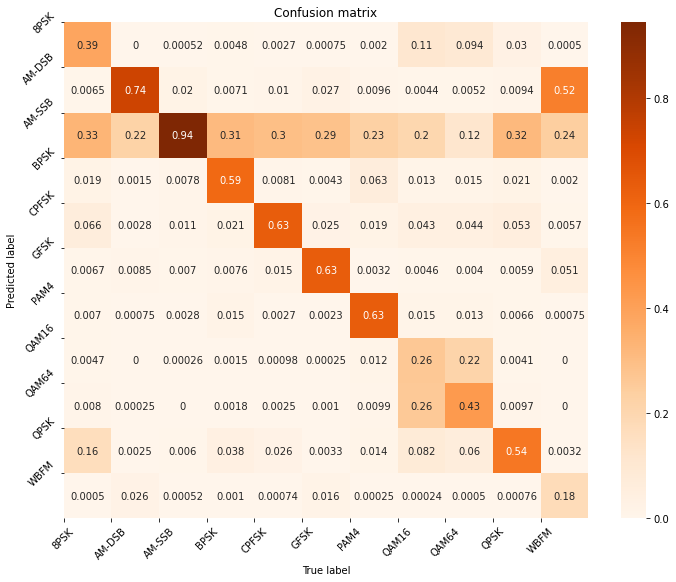

11/11 [==============================] - 0s 5ms/step


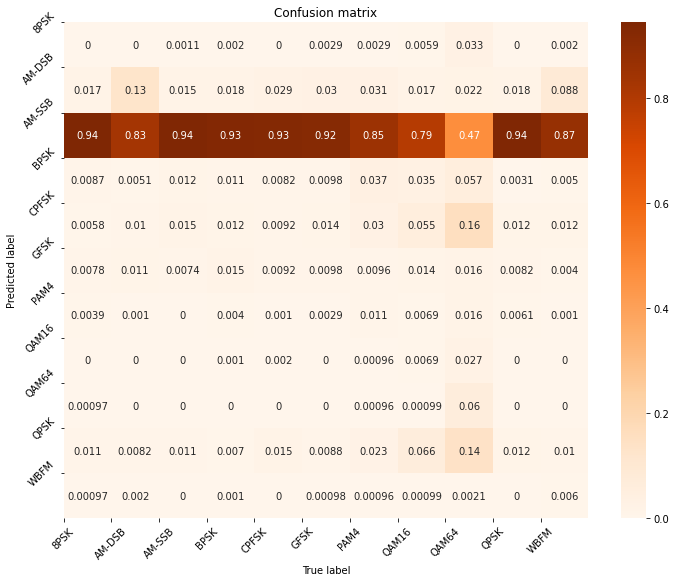

18/18 [==============================] - 0s 5ms/step


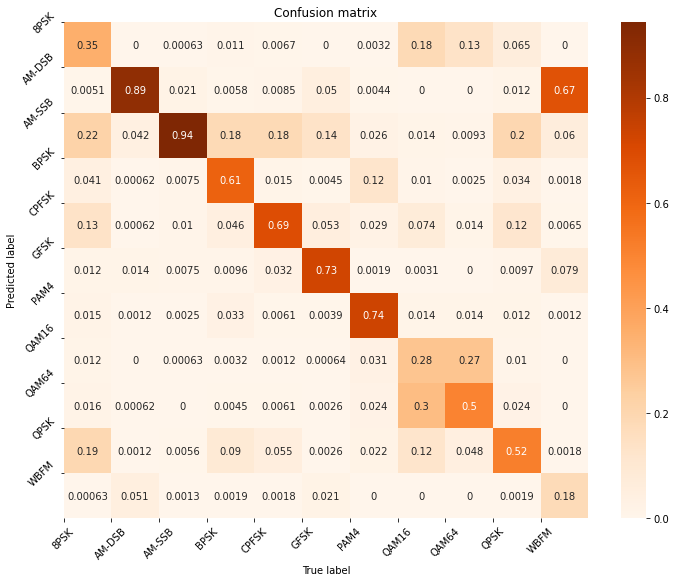

16/16 [==============================] - 0s 5ms/step


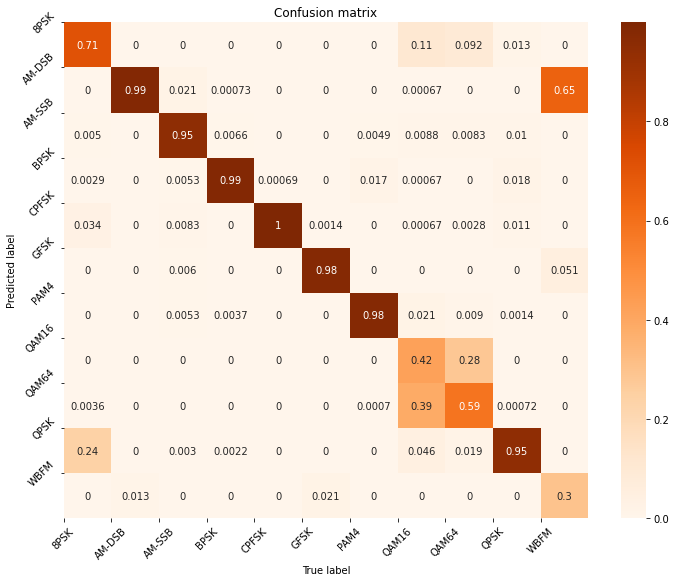

3/3 [==============================] - 0s 5ms/step


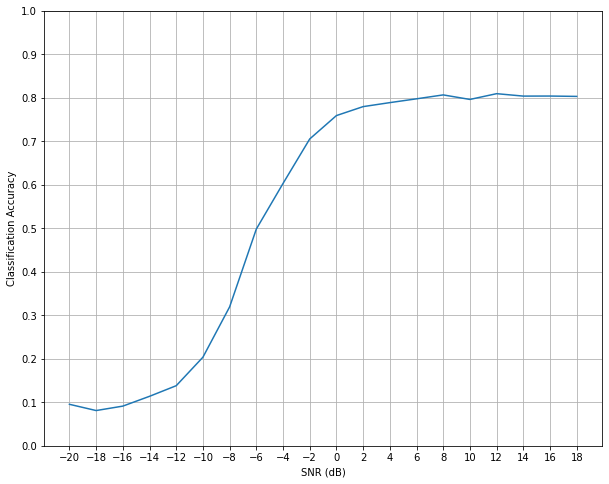

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_IQ' )
cldnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_model_evaluater.print_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_9 (ZeroPadding2  (None, 1, 2, 132)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_9[0][0]']       
                                                                                                  
 dropout_12 (Dropout)           (None, 50, 2, 125)   0           ['conv1[0][0]']            

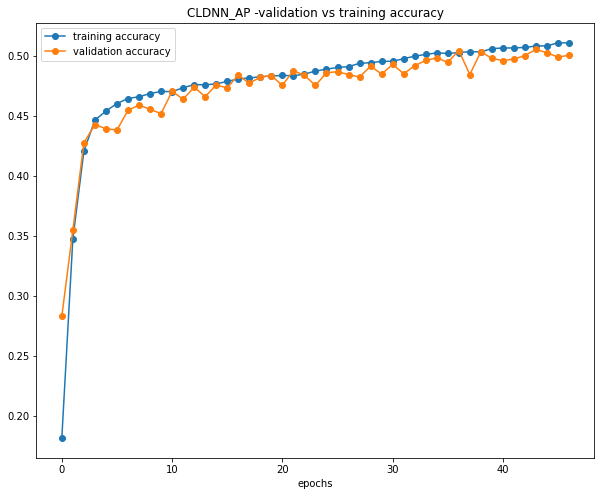

None

43/43 [==============================] - 1s 7ms/step


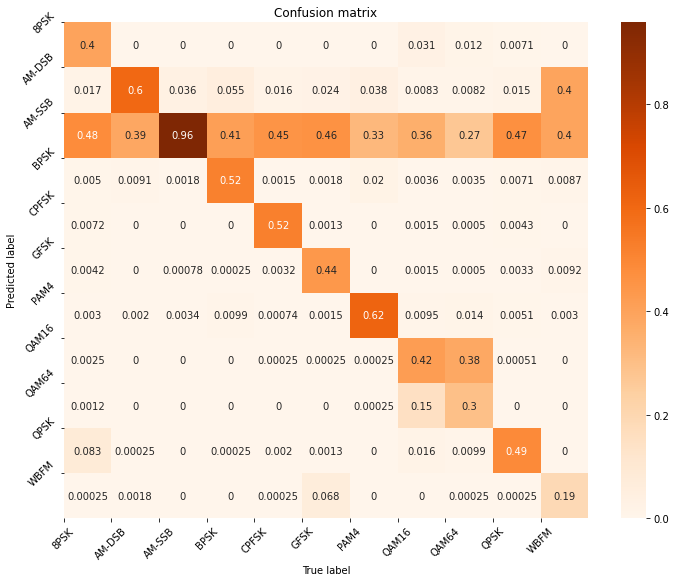

11/11 [==============================] - 0s 12ms/step


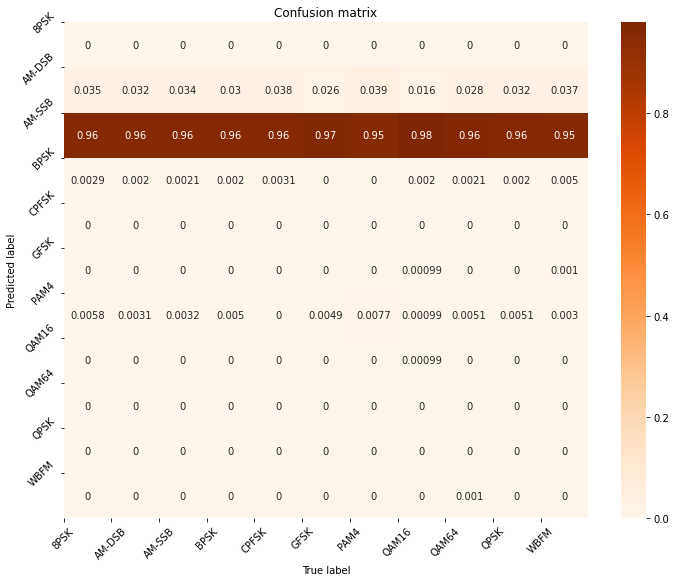

18/18 [==============================] - 0s 6ms/step


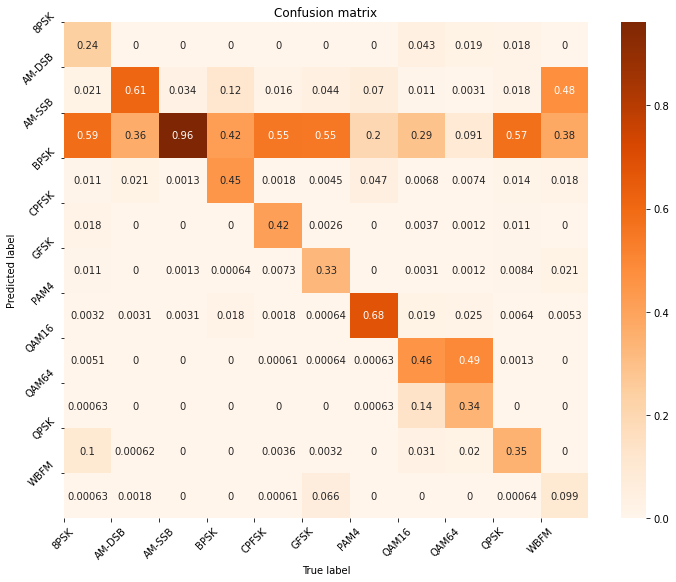

16/16 [==============================] - 0s 6ms/step


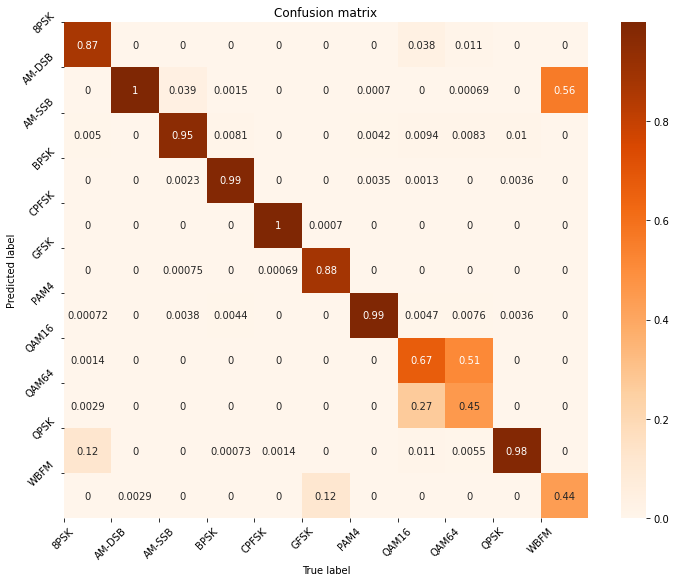

3/3 [==============================] - 0s 17ms/step


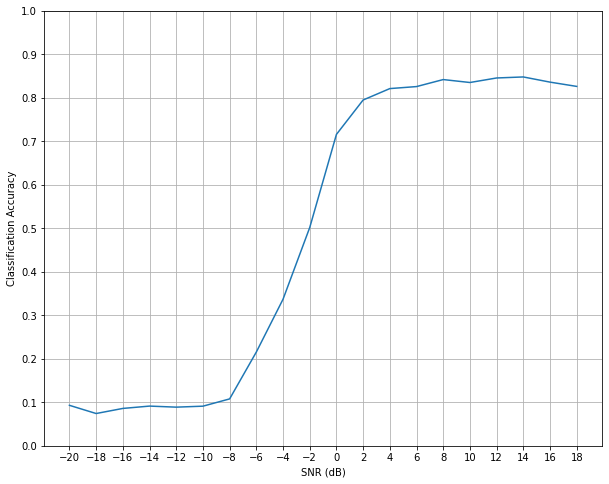

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_AP' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

In [ ]:
def build_cgdnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)

  concat = keras.layers.concatenate([layer1, layer3])
  
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  gru_out = GRU(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1")(gru_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, kernel_initializer='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 1, 2, 132)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 50, 2, 125)   0           ['conv1[0][0]']                  
                                                                                              

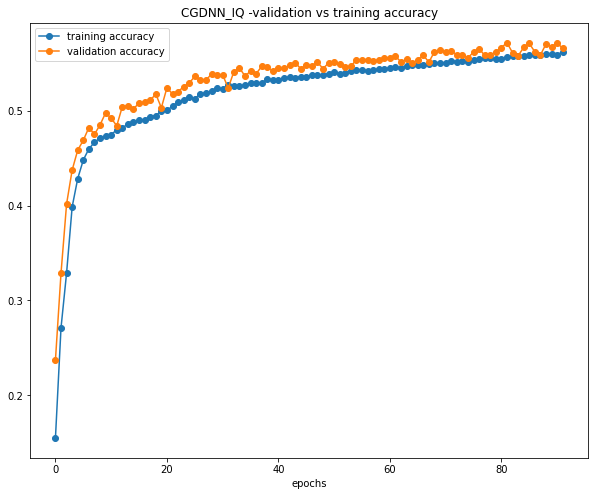

None

43/43 [==============================] - 2s 36ms/step


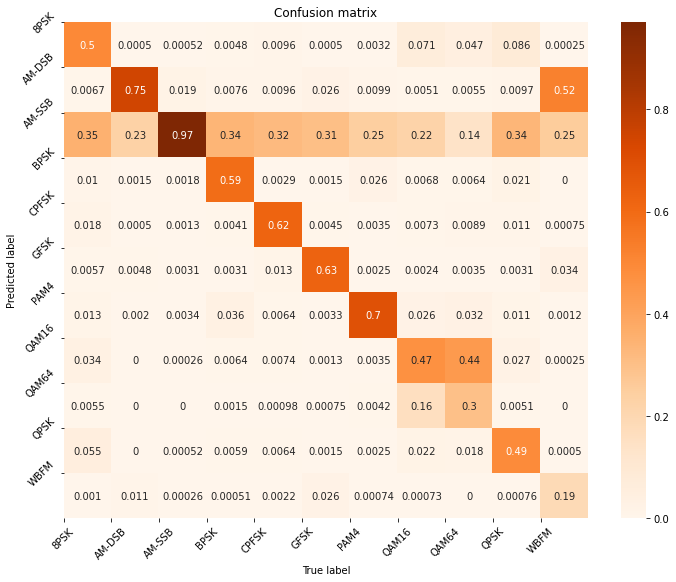

11/11 [==============================] - 1s 75ms/step


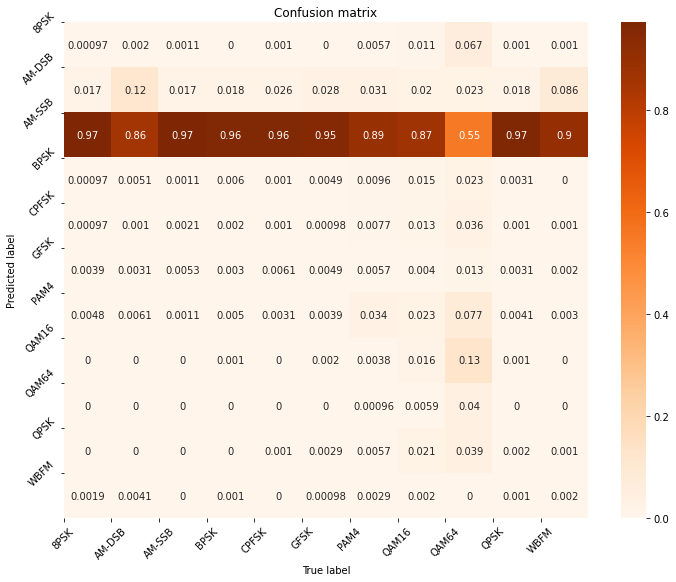

18/18 [==============================] - 1s 68ms/step


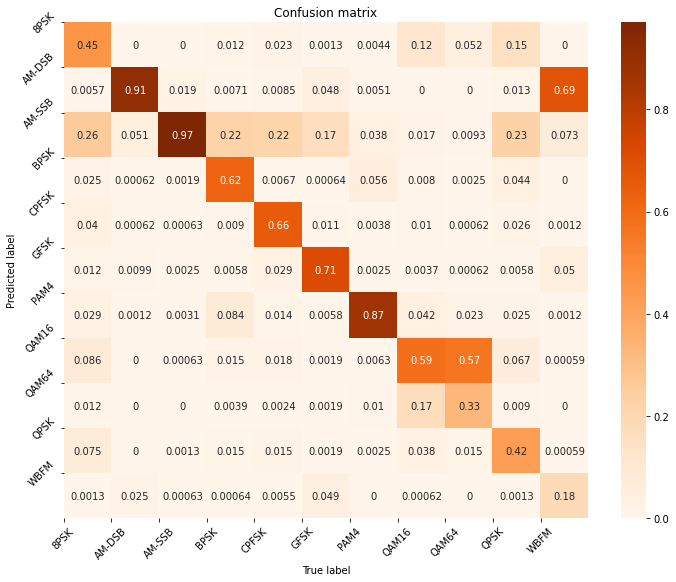

16/16 [==============================] - 1s 44ms/step


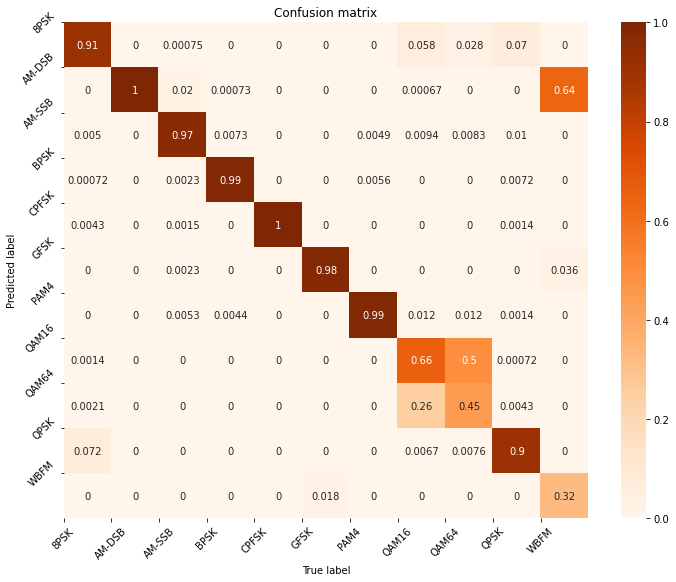

3/3 [==============================] - 1s 370ms/step


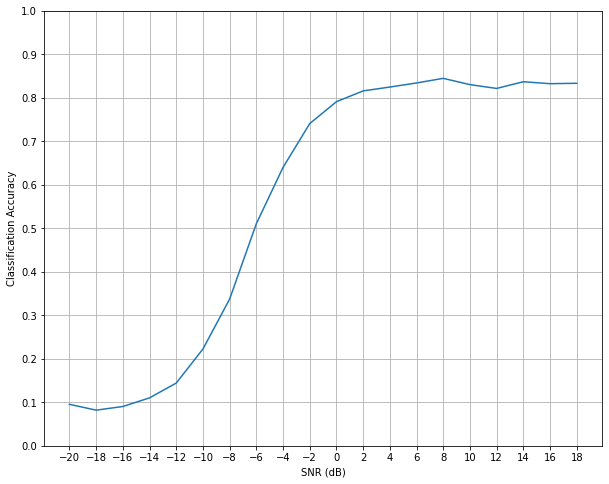

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cgdnn_model = build_cgdnn_net(X_test.shape[1], X_test.shape[2])
cgdnn_model_evaluater = ModelEvaluater(cgdnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'CGDNN_IQ' )
cgdnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cgdnn_model_evaluater.print_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 1, 2, 132)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_3[0][0]']       
                                                                                                  
 dropout_4 (Dropout)            (None, 50, 2, 125)   0           ['conv1[0][0]']            

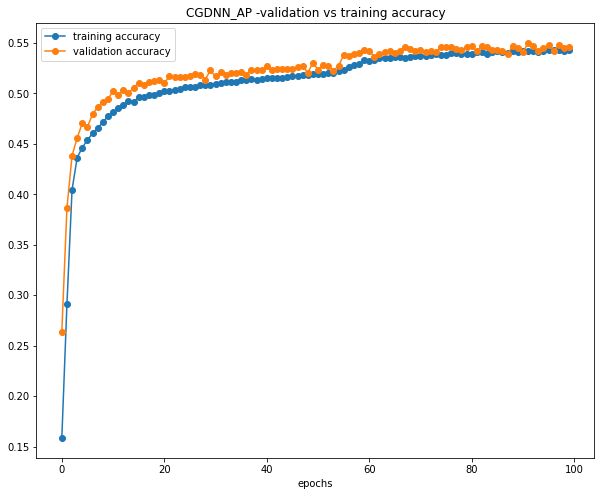

None

43/43 [==============================] - 1s 20ms/step


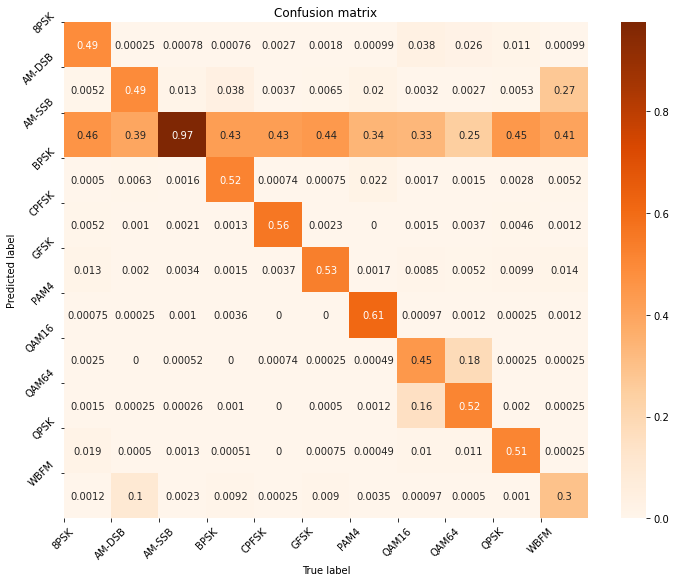

11/11 [==============================] - 0s 19ms/step


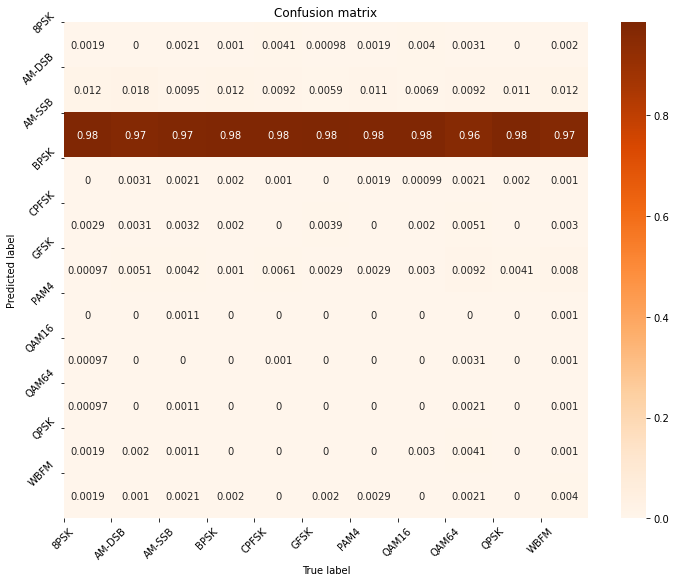

18/18 [==============================] - 0s 20ms/step


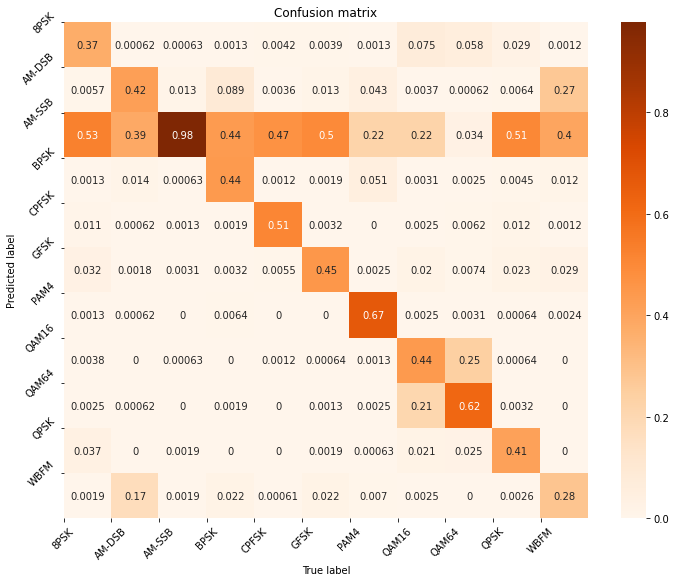

16/16 [==============================] - 0s 20ms/step


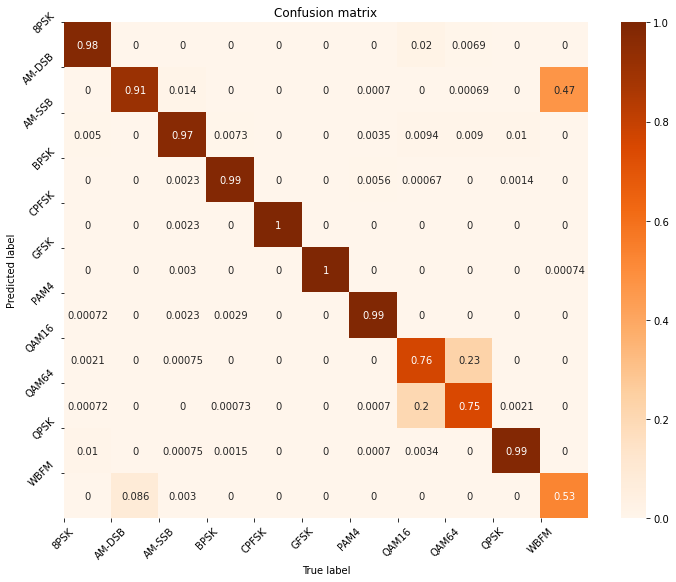

3/3 [==============================] - 0s 19ms/step


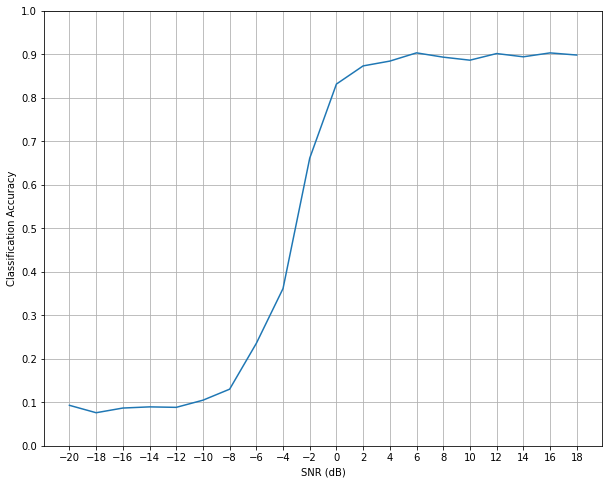

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cgdnn_ap_model = build_cgdnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cgdnn_ap_model_evaluater = ModelEvaluater(cgdnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'CGDNN_AP' )
cgdnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cgdnn_ap_model_evaluater.print_summary()

In [ ]:
def build_lstm_net(X1, X2):
  model = Sequential()
  model.add(LSTM(X2, input_shape=(X2, X1), return_sequences=True, name='lstm1', dropout=0.2, recurrent_dropout=0))#1.0,0.8
  model.add(LSTM(X2, name='lstm2', dropout=0.2, recurrent_dropout=0))#0.8,1.0
  model.add(Dense(NUM_CLASSES, activation='softmax', name='dense1'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128, 128)          67072     
                                                                 
 lstm2 (LSTM)                (None, 128)               131584    
                                                                 
 dense1 (Dense)              (None, 11)                1419      
                                                                 
Total params: 200,075
Trainable params: 200,075
Non-trainable params: 0
_________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 2.3263 - accuracy: 0.1272
Epoch 1: val_loss improved from inf to 2.23353, saving model to /content/gdrive/My Drive/all class 33/LSTM_IQ-weights-1.hdf5
144/144 [==============================] - 20s 109

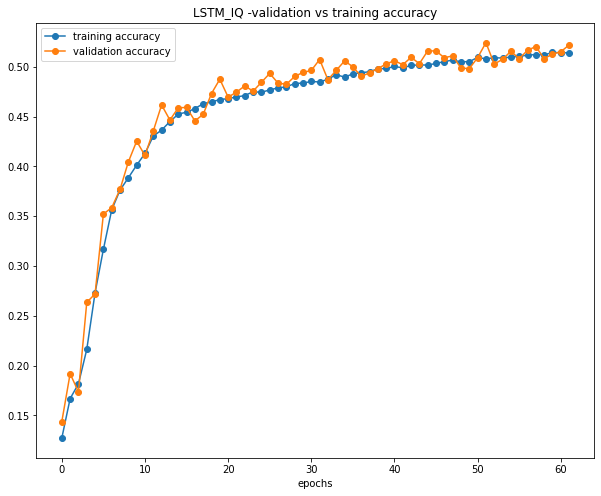

None

43/43 [==============================] - 2s 33ms/step


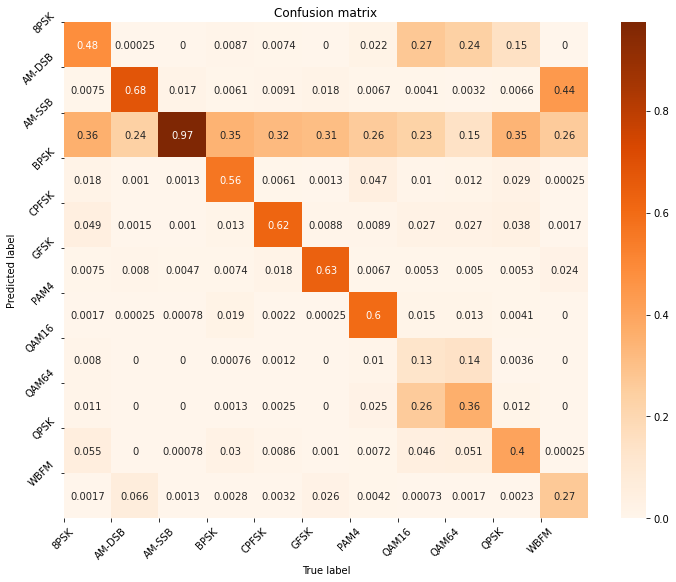

11/11 [==============================] - 0s 36ms/step


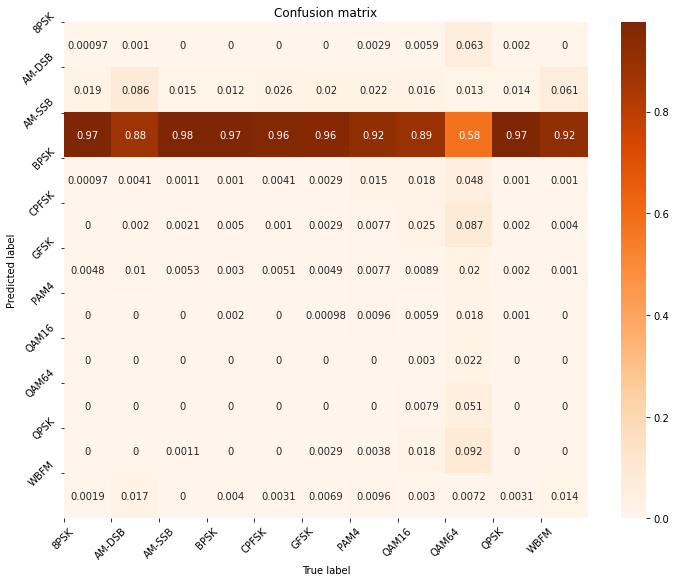

18/18 [==============================] - 1s 30ms/step


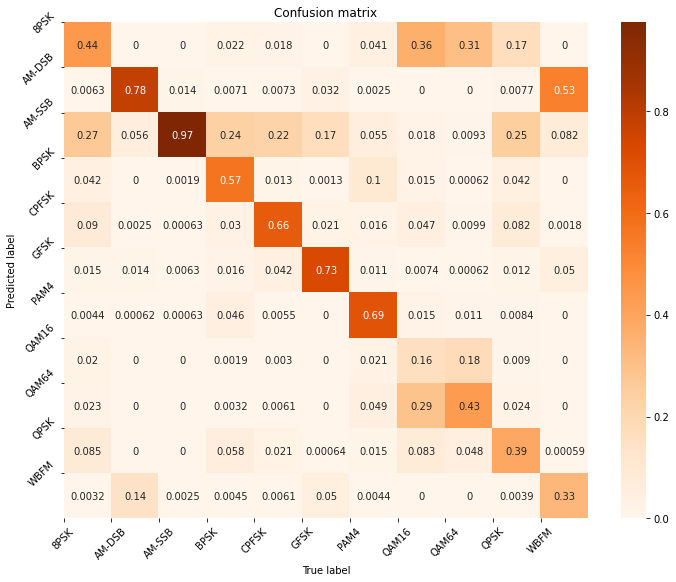

16/16 [==============================] - 0s 30ms/step


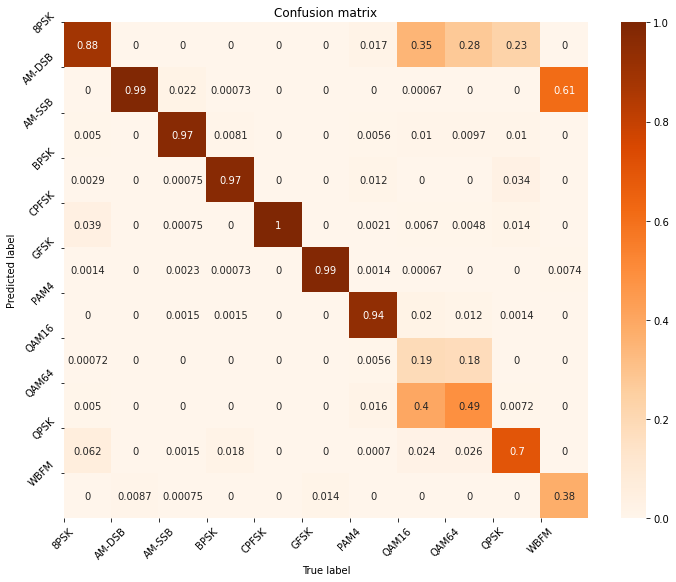

3/3 [==============================] - 0s 30ms/step


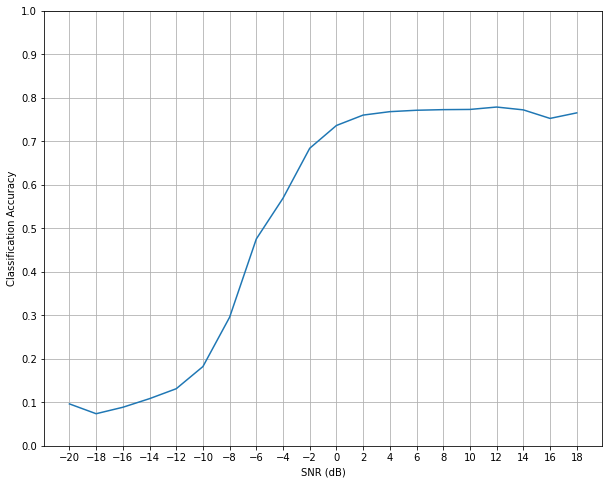

In [ ]:
#Ｎeed to reshape data to fit into lstm model
X_train3 = X_train.reshape(-1, 128, 2)
X_val3 = X_val.reshape(-1, 128, 2)
X_test3 = X_test.reshape(-1, 128, 2)

lstm_model = build_lstm_net(X_train.shape[1], X_train.shape[2])
lstm_model_evaluater = ModelEvaluater(lstm_model, X_train3, y_train, X_val3, y_val, X_test3, y_test, labels_test, BATCH_SIZE, 'LSTM_IQ' )
lstm_model_evaluater.fit(EPOCHS, patience=PATIENCE)
lstm_model_evaluater.print_summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128, 128)          67072     
                                                                 
 lstm2 (LSTM)                (None, 128)               131584    
                                                                 
 dense1 (Dense)              (None, 11)                1419      
                                                                 
Total params: 200,075
Trainable params: 200,075
Non-trainable params: 0
_________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 2.2103 - accuracy: 0.1815
Epoch 1: val_loss improved from inf to 2.04212, saving model to /content/gdrive/My Drive/all class 33/LSTM_AP-weights-1.hdf5
144/144 [==============================] - 20s 106

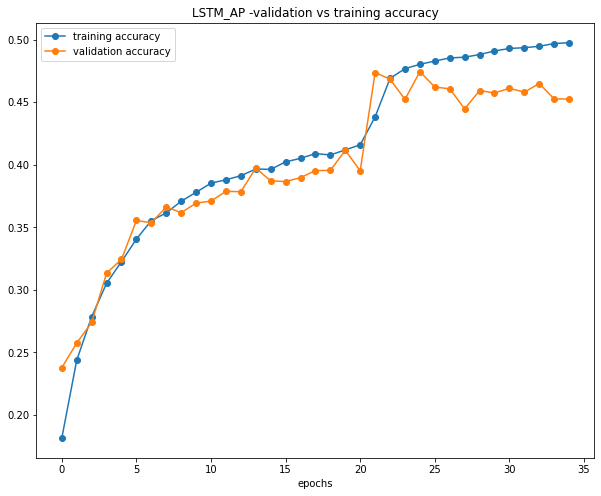

None

43/43 [==============================] - 2s 31ms/step


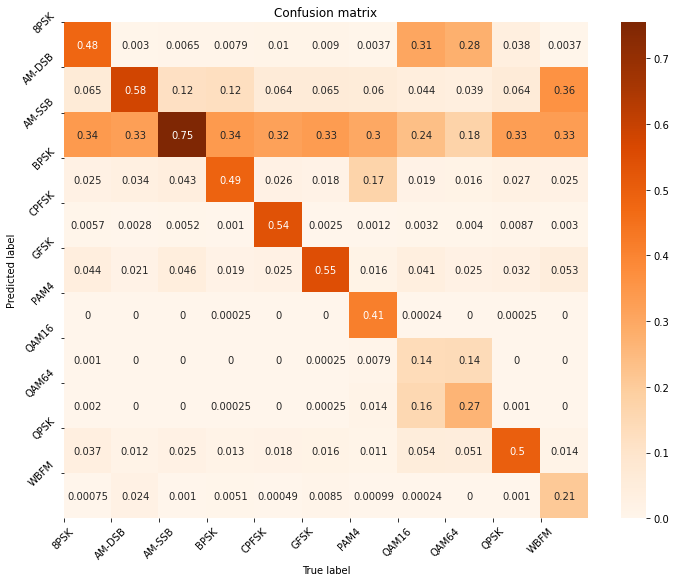

11/11 [==============================] - 0s 32ms/step


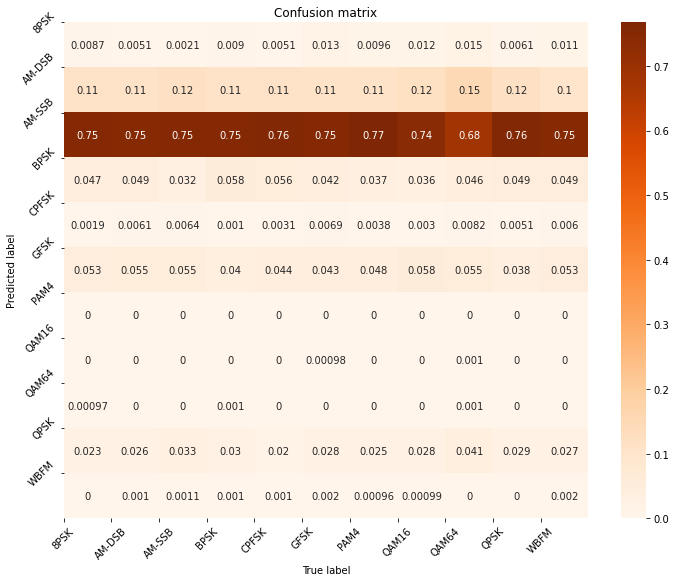

18/18 [==============================] - 1s 31ms/step


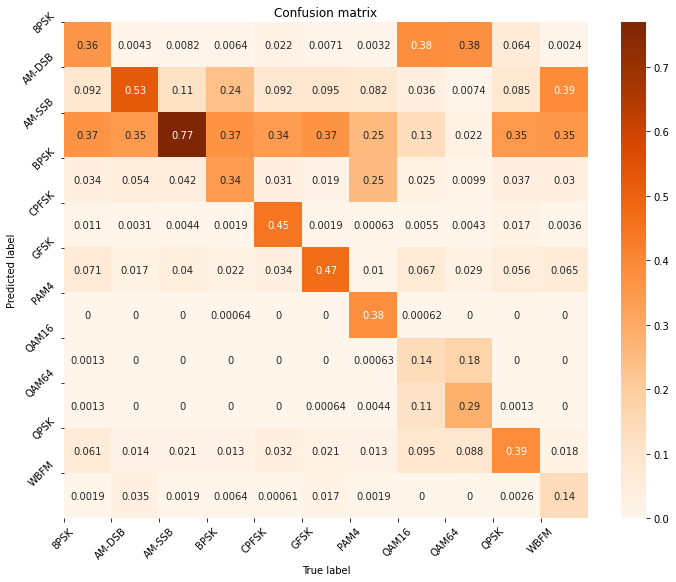

16/16 [==============================] - 0s 30ms/step


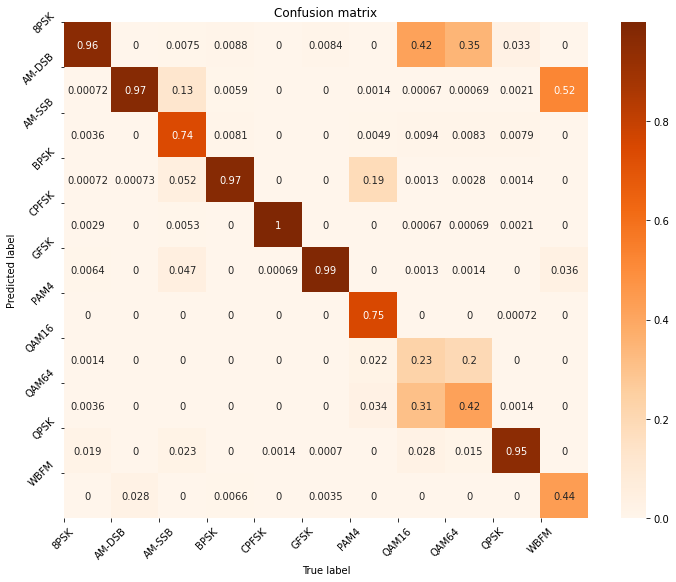

3/3 [==============================] - 0s 29ms/step


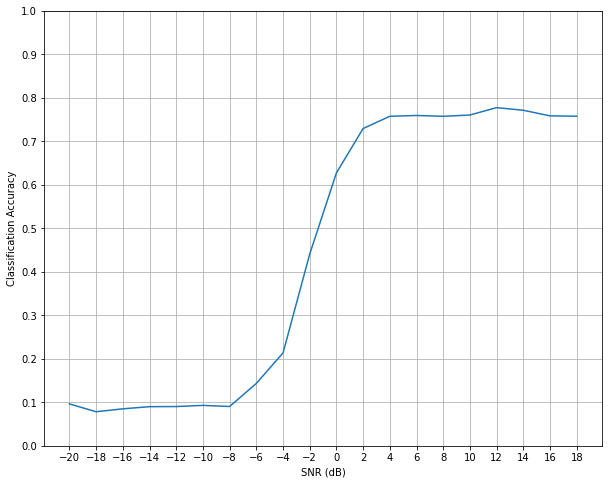

In [ ]:
#Ｎeed to reshape data to fit into lstm model
X_ap_train3 = X_ap_train.reshape(-1, 128, 2)
X_ap_val3 = X_ap_val.reshape(-1, 128, 2)
X_ap_test3 = X_ap_test.reshape(-1, 128, 2)

lstm_ap_model = build_lstm_net(X_ap_train.shape[1], X_ap_train.shape[2])
lstm_ap_model_evaluater = ModelEvaluater(lstm_ap_model, X_ap_train3, y_train, X_ap_val3, y_val, X_ap_test3, y_test, labels_test, BATCH_SIZE, 'LSTM_AP' )
lstm_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
lstm_ap_model_evaluater.print_summary()

In [ ]:
#CNN_IQ
cnn_model = build_cnn_net(X_test.shape[1], X_test.shape[2])
cnn_model.load_weights(root_path + 'CNN_IQ-weights-55.hdf5')
cnn_model_evaluater = ModelEvaluater(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'CNN_IQ' )
cnn_accpersnr = cnn_model_evaluater.accpersnr_model()

#CNN_AP
cnn_ap_model = build_cnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cnn_ap_model.load_weights(root_path + 'CNN_AP-weights-14.hdf5')
cnn_ap_model_evaluater = ModelEvaluater(cnn_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'CNN_AP' )
cnn_ap_accpersnr = cnn_ap_model_evaluater.accpersnr_model()

#RESNET_IQ
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model.load_weights(root_path + 'RESNET_IQ-weights-70.hdf5')
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'RESNET_IQ', channels_first=False)
resnet_accpersnr = resnet_model_evaluater.accpersnr_model()

#RESNET_AP
resnet_ap_model = build_ResNet((X_ap_test.shape[2], X_ap_test.shape[1]), NUM_CLASSES)
resnet_ap_model.load_weights(root_path + 'RESNET_AP-weights-60.hdf5')
resnet_ap_model_evaluater = ModelEvaluater(resnet_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'RESNET_AP', channels_first=False)
resnet_ap_accpersnr = resnet_ap_model_evaluater.accpersnr_model()

#CLDNN_IQ
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'CLDNN_IQ-weights-64.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_IQ' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()

#CLDNN_AP
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'CLDNN_AP-weights-37.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_AP' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()

#LSTM_IQ
#Need to reshape data to fit into lstm model
X_train3 = X_train.reshape(-1, 128, 2)
X_val3 = X_val.reshape(-1, 128, 2)
X_test3 = X_test.reshape(-1, 128, 2)
lstm_model = build_lstm_net(X_train.shape[1], X_train.shape[2])
lstm_model.load_weights(root_path + 'LSTM_IQ-weights-52.hdf5')
lstm_model_evaluater = ModelEvaluater(lstm_model, X_train3, y_train, X_val3, y_val, X_test3, y_test, labels_test, BATCH_SIZE, 'LSTM_IQ' )
lstm_accpersnr = lstm_model_evaluater.accpersnr_model()

#LSTM_AP
#Need to reshape data to fit into lstm model
X_ap_train3 = X_ap_train.reshape(-1, 128, 2)
X_ap_val3 = X_ap_val.reshape(-1, 128, 2)
X_ap_test3 = X_ap_test.reshape(-1, 128, 2)
lstm_ap_model = build_lstm_net(X_ap_train.shape[1], X_ap_train.shape[2])
lstm_ap_model.load_weights(root_path + 'LSTM_AP-weights-25.hdf5')
lstm_ap_model_evaluater = ModelEvaluater(lstm_ap_model, X_ap_train3, y_train, X_ap_val3, y_val, X_ap_test3, y_test, labels_test, BATCH_SIZE, 'LSTM_AP' )
lstm_ap_accpersnr = lstm_ap_model_evaluater.accpersnr_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 2, 126)       1024      
                                                                 
 dropout_34 (Dropout)        (None, 256, 2, 126)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 1, 124)        122960    
                                                                 
 dropout_35 (Dropout)        (None, 80, 1, 124)        0         
                                                                 
 flatten_4 (Flatten)         (None, 9920)              0         
                                                                 
 dense_10 (Dense)            (None, 256)              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 142,019
Trainable params: 142,019
Non-trainable params: 0
__________________________________________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
3/3 [==============================] - 0s 5ms/step
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 2)]     0           []                               
                                                                                                  
 conv1d_75 (Conv1D)             (None, 128, 40)      120         ['input_10[0][0]']               
                                                                                                  
 activation_81 (Activation)     (None, 128, 40)      0           ['conv1d_75[0][0]']              
                            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
Total params: 142,019
Trainable params: 142,019
Non-trainable params: 0
__________________________________________________________________________________________________
y_train 147400
y_val 28600
y_test 44000
3/3 [==============================] - 0s 5ms/step
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 1, 2, 132)   0           ['input_11[0][0]']               
 2D)                                                                                              
                           

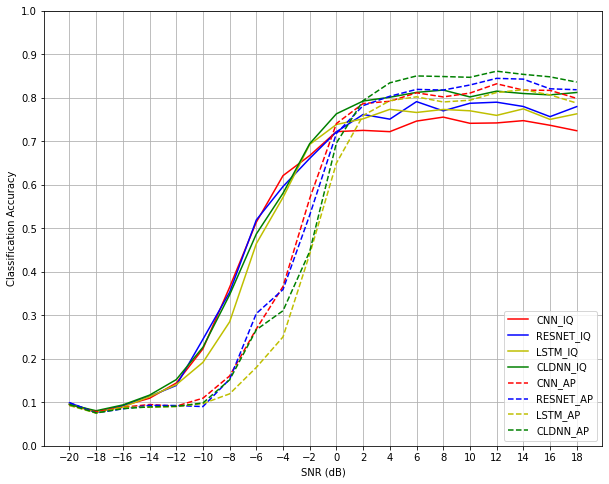

In [ ]:
# plot acc-vs-snr graphs for different models
cnn,  = plt.plot(list(cnn_accpersnr.keys()),list(cnn_accpersnr.values()), 'r-', label='CNN_IQ')
#inception, = plt.plot(list(cnn_inc_accpersnr.keys()),list(cnn_inc_accpersnr.values()), 'k-', label='Inception_IQ')
#inception2, = plt.plot(list(cnn_inc2_accpersnr.keys()),list(cnn_inc2_accpersnr.values()), 'm-', label='Inception2_IQ')
#cgdnn, = plt.plot(list(cgdnn_accpersnr.keys()),list(cgdnn_accpersnr.values()), 'g-', label='CGDNN_IQ')
#rldnn, = plt.plot(list(rldnn_accpersnr.keys()),list(rldnn_accpersnr.values()), 'g-', label='RLDNN_IQ')
resnet,  = plt.plot(list(resnet_accpersnr.keys()),list(resnet_accpersnr.values()), 'b-', label='RESNET_IQ')
lstm, = plt.plot(list(lstm_accpersnr.keys()),list(lstm_accpersnr.values()), 'y-', label='LSTM_IQ')
cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='CLDNN_IQ')

cnn_ap,  = plt.plot(list(cnn_ap_accpersnr.keys()),list(cnn_ap_accpersnr.values()), 'r--', label='CNN_AP')
#inception_ap, = plt.plot(list(cnn_inc_ap_accpersnr.keys()),list(cnn_inc_ap_accpersnr.values()), 'k--', label='Inception_AP')
#inception2_ap, = plt.plot(list(cnn_inc2_ap_accpersnr.keys()),list(cnn_inc2_ap_accpersnr.values()), 'm--', label='Inception2_AP')
resnet_ap,  = plt.plot(list(resnet_ap_accpersnr.keys()),list(resnet_ap_accpersnr.values()), 'b--', label='RESNET_AP')
lstm_ap, = plt.plot(list(lstm_ap_accpersnr.keys()),list(lstm_ap_accpersnr.values()), 'y--', label='LSTM_AP')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='CLDNN_AP')

plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy")
plt.xticks(list(cnn_accpersnr.keys()))
plt.legend(handles = [cnn, resnet, lstm, cldnn, cnn_ap, resnet_ap, lstm_ap, cldnn_ap])
plt.legend(loc="lower right")#
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()